# COMP551 Project3 CNN Group11

Eric Shen 260798146

Stephen Shen


## Loading and Normalizing CIFAR10

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
#torchvision output is PILImage, the value range is [0,1]
#We convert it to tensor data and normalize it to [-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Training set, load all the data in the cifar-10-batches-py folder under the relative directory ./data (50,000 pictures as training data) into the memory, if download is True, the data will be automatically downloaded from the Internet And unzip
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
                                        
## Divide the 50000 pictures of the training set into 12500 copies, each with 4 pictures for mini-batch input shffule = True when traversing different batches of data, the order is shuffled. num_workers = 2 means use two child processes to load data                                     download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
#Test set, load all data (10000 pictures as test data) in the cifar-10-batches-py folder in the relative directory ./data into the memory,
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#Divide the 10,000 pictures of the test set into 2500, 4 pictures for each copy, for mini-batch input
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
#create a class for different outcomes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Preprocess

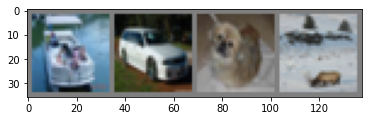

 ship   car   dog  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # Convert torch.FloatTensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #Convert the format of the picture from (channels, imagesize, imagesize) to (imagesize, imagesize, channels)
    plt.show() #Show picture

# get some random training images
dataiter = iter(trainloader)#load the training data into the trainloader and make it an iterator
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Convolutional Neural Network

### Training


Define a Convolutional Neural Network

In [0]:
import torch.nn as nn
import torch.nn.functional as F

#this class is to define a CNN model
class Net(nn.Module):
    def __init__(self):
      #initialize the empty model
        super(Net, self).__init__()
        # The first layer in a CNN is a Convolutional Layer.# Define the conv1 function is the image convolution function: the input is an image (3 channels, that is, color image), the output is 6 feature maps, and the convolution kernel is 5x5 square
        self.conv1 = nn.Conv2d(3, 6, 5)
        #pooling layer to reduce the dimensions by 2.
        self.pool = nn.MaxPool2d(2, 2)
        # Define the conv2 function is the image convolution function: the input is an image (6 channels, that is, color image), the output is 16 feature maps, and the convolution kernel is 5x5 square
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Full connection function; image size 5 * 5, channel is 16, connect 16 * 5 * 5 nodes to 120 nodes      
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Full connection function; connect 120 nodes to 84 nodes
        self.fc2 = nn.Linear(120, 84)
        # Full connection function; connect 84 nodes to 10 nodes
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Input x goes through conv1, and it goes through activation function ReLU
        x = self.pool(F.relu(self.conv1(x)))
        # Input x goes through conv2, and it goes through activation function ReLU
        x = self.pool(F.relu(self.conv2(x)))
        # The view function transforms the tensor x into a one-dimensional vector form, and the total number of features does not change, preparing for the next full connection.
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))#Enter x through the full connection 1, then through the ReLU activation function, and then update x
        x = F.relu(self.fc2(x))#Enter x through the full connection 2, then through the ReLU activation function, and then update x
        x = self.fc3(x)
        return x

net = Net()

Define a Loss function and optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()#Cross entropy loss function

#Using SGD (stochastic gradient descent) optimization, the learning rate is 0.001 and the momentum is 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the network

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    #enumerate (sequence, [start = 0]), i serial number, data is data
    for i, data in enumerate(trainloader, 0):
        #get the inputs; data is a list of [inputs, labels] 
        #The structure of #data is: [4x3x32x32 tensor, length 4 tensor]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #The output and labels use cross entropy to calculate the loss
        loss = criterion(outputs, labels)
        #Back propagation
        loss.backward()
        #Update parameters with SGD
        optimizer.step()

        # print statistics
        # Print the average loss value every 2000 batches of data
        #loss itself is of Variable type, so use data to get its Tensor, because it is a scalar, so take 0
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.205
[1,  4000] loss: 1.881
[1,  6000] loss: 1.652
[1,  8000] loss: 1.581
[1, 10000] loss: 1.498
[1, 12000] loss: 1.443
[2,  2000] loss: 1.399
[2,  4000] loss: 1.373
[2,  6000] loss: 1.327
[2,  8000] loss: 1.325
[2, 10000] loss: 1.291
[2, 12000] loss: 1.276
Finished Training


In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Result

Accuracy on training set

In [10]:
correct = 0 # Define the number of pictures predicted correctly, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
with torch.no_grad():
  for data in trainloader: 
        images1, labels1 = data#The structure of #data is: [4x3x32x32 tensor, length 4 tensor]
        outputs = net(images1)# forward + backward + optimize
        #print outputs.data
        _, predicted = torch.max(outputs.data, 1)# outputs.data is a 4x10 tensor, which returns the largest column value and serial number of each row to form a one-dimensional tensor, the first is the value tensor, and the second is the serial number tensor.
        total += labels1.size(0) # Update the number of test pictures
        correct += (predicted == labels1).sum().item()#Two one-dimensional tensors are compared line by line. The same line is recorded as 1, and the different lines are recorded as 0. Then, sum () is used to sum up to get the same number.
print('Accuracy of the network on the 50000 training images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 50000 training images: 56 %


Accuracy on test set

In [11]:
correct = 0 # Define the number of pictures predicted correctly, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
confusion_matrix = np.zeros([10,10], int)

with torch.no_grad():
    for data in testloader: # Loop every batch
        images, labels = data#The structure of #data is: [4x3x32x32 tensor, length 4 tensor]
        outputs = net(images)# forward + backward + optimize
        #print outputs.data
        _, predicted = torch.max(outputs.data, 1)# outputs.data is a 4x10 tensor, which returns the largest column value and serial number of each row to form a one-dimensional tensor, the first is the value tensor, and the second is the serial number tensor
        total += labels.size(0)# Update the number of test pictures
        correct += (predicted == labels).sum().item()#Two one-dimensional tensors are compared line by line. The same line is recorded as 1, and the different lines are recorded as 0. Then, sum () is used to sum up to get the same number.
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total)) # Last print result

Accuracy of the network on the 10000 test images: 54 %


Result per class

In [12]:
class_correct = list(0. for i in range(10))# Define a list that stores the correct number of tests in each category, initialized to 0
class_total = list(0. for i in range(10))# Define a list that stores the total number of tests in each category, initialized to 0

with torch.no_grad():
    for data in testloader: # Cycle through a batch
        images, labels = data#The structure of #data is: [4x3x32x32 tensor, length 4 tensor]
        outputs = net(images)# forward + backward + optimize
        _, predicted = torch.max(outputs, 1)# outputs.data is a 4x10 tensor, which returns the largest column value and serial number of each row to form a one-dimensional tensor, the first is the value tensor, and the second is the serial number tensor
        c = (predicted == labels).squeeze()
        for i in range(4):# Because each batch has 4 pictures, it also needs a 4 small loop
            label = labels[i]# Add each category separately
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 47 %
Accuracy of  bird : 39 %
Accuracy of   cat : 21 %
Accuracy of  deer : 59 %
Accuracy of   dog : 56 %
Accuracy of  frog : 48 %
Accuracy of horse : 54 %
Accuracy of  ship : 74 %
Accuracy of truck : 72 %


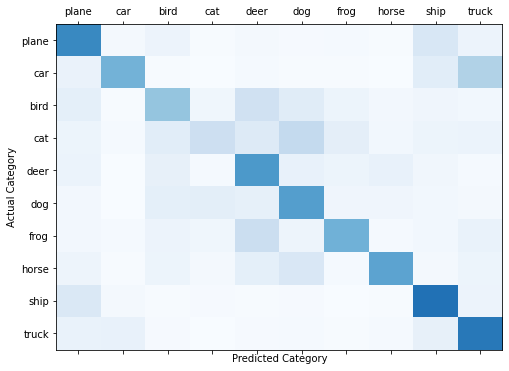

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()